### Convolution filters and CNNs applied to image classification

The goal of this notebook is to learn and build an intuition on the convolution operation in machine learning and how the CNNs work. We will learn this in the framework of image classification, in which CNNs are widely used.

For this we will use a set of handwritten character digits from NIST database

In [ ]:
%matplotlib inline
import math,sys,os,numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
import torch
import torchvision
from torchvision import models,transforms,datasets

In [4]:
root_dir = './data/MNIST/'
torchvision.datasets.MNIST(root=root_dir,download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST/
    Split: Train

In [5]:
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True)

In [6]:
MNIST_dataset = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)

#### We can format data as _numpy ndarrays_ which are easier to plot in matplotlib.

In [7]:
images = train_set.data.numpy().astype(np.float32)/255
labels = train_set.targets.numpy()

print(images.shape,labels.shape)

(60000, 28, 28) (60000,)


We define functions for plotting our image data

In [8]:
# plot multiple images
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

# plot a single image
def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

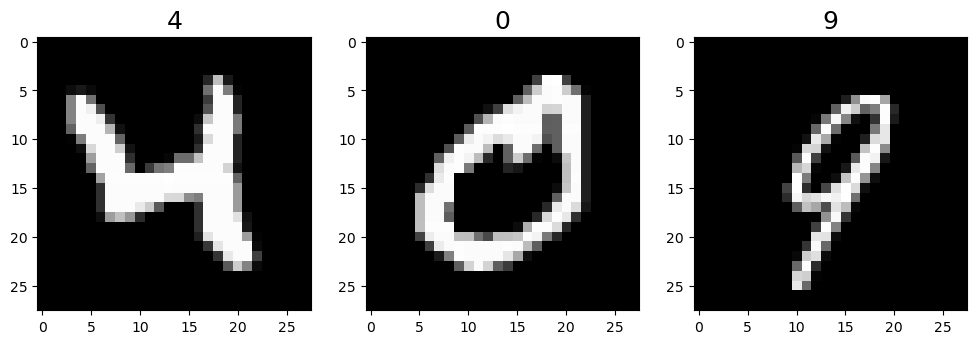

In [9]:
plots(np.array([images[20],images[21],images[22]]),titles=[labels[20],labels[21],labels[22]])

### Understand Filters and Convolution

Here we define simple 3x3 filters to see the effects of the convultion operation

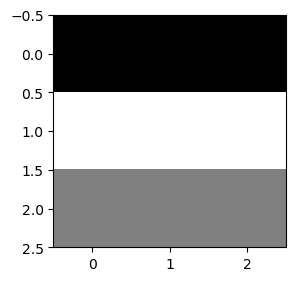

In [10]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

plot(top)

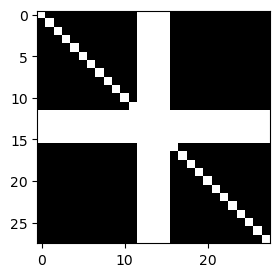

In [11]:
cross = np.zeros((28,28))
cross += np.eye(28)
for i in range(4):
    cross[12+i,:] = np.ones(28)
    cross[:,12+i] = np.ones(28)

plot(cross)

C:\Users\user\AppData\Local\Temp\ipykernel_17764\648623620.py:1: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve, correlate
C:\Users\user\AppData\Local\Temp\ipykernel_17764\648623620.py:1: DeprecationWarning: Please import `correlate` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve, correlate


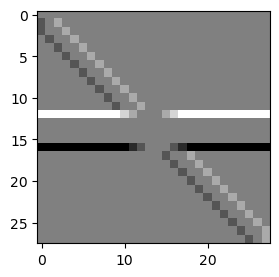

In [12]:
from scipy.ndimage.filters import convolve, correlate

corr_cross = correlate(cross,top)

plot(corr_cross)

Now we check with different more complex filters 

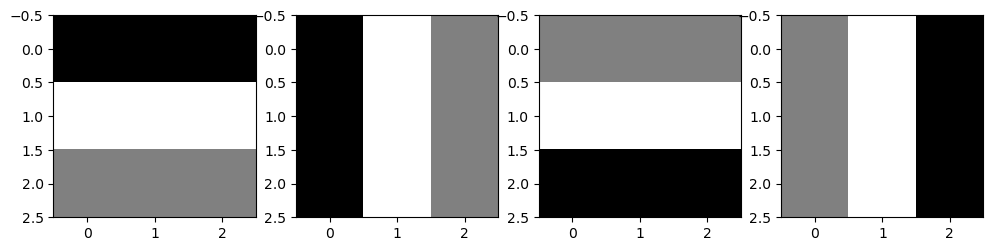

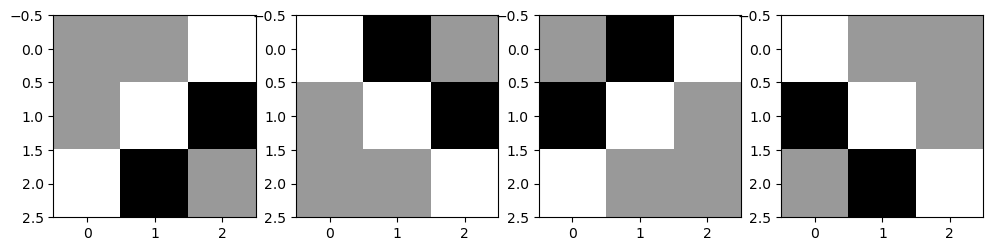

In [13]:
straights=[np.rot90(top,i) for i in range(4)]
plots(straights)
br=[[ 0, 0, 1],
    [ 0, 1,-1.5],
    [ 1,-1.5, 0]]

diags = [np.rot90(br,i) for i in range(4)]
plots(diags)

We compose theses filters

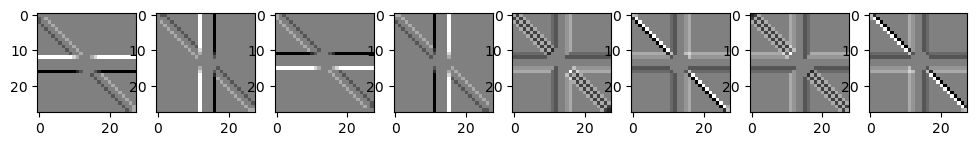

In [14]:
filters = straights + diags
corrs_cross = [correlate(cross, filter) for filter in filters]
plots(corrs_cross)

Let's see what we have on an image

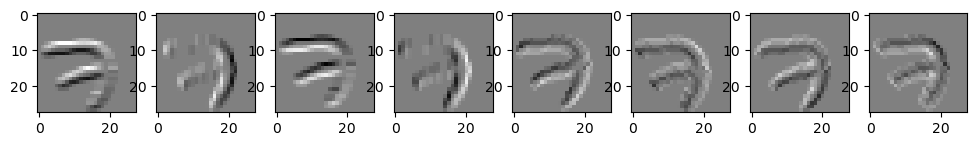

In [15]:
corrs = [correlate(images[5000],filter) for filter in filters]
plots(corrs)

Next we illustrate the effect of downsampling.
We select the most basic downsampling technique: __max pooling__. We keep only the maximum value for sliding windows of size ```7x7```.
__Max pooling__ is a handy technique with a few useful benefits:
- since it selects the maximum values it ensures invariance to translations
- reducing the size is helpful since data becomes more compact and easier to compare
- since max pooling reduces the size of our images, the operations performed later on in the network have bigger receptive field / concern a bigger patch in the input image and allow the discovery of higher level patterns.

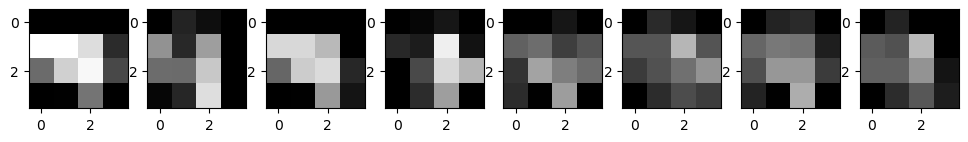

In [16]:
import skimage

from skimage.measure import block_reduce

def pool(im): return block_reduce(im, (7,7), np.max)

plots([pool(im) for im in corrs])

We now build a classifier with convolutions.

To this end we select a set of training images depicting _sixes_ and _ones_, we convolve them with our set of filters, pool them and average them for each class and filter. We will thus obtain a set of _representative_ signatures for _sixes_ and for _ones_. 
Given a new test image we compute its features by convolution and pooling with the same filters and then compare them with the _representative_ features. The class with the most _similar_ features is chosen as prediction.


We keep 1000 images of _sixes_ for the test set and use the remaining ones for the training: we convolve them with our bank of filters, perform max pooling on the responses and store them in ```pool6```.

In [17]:
n=len(images)
sixes=[images[i] for i in range(n) if labels[i]==6]
ones=[images[i] for i in range(n) if labels[i]==1]

len(sixes),len(ones)

(5918, 6742)

In [18]:
pool6 = [np.array([pool(correlate(im, filter)) for im in sixes[1000:]]) for filter in filters]
pool1 = [np.array([pool(correlate(im, filter)) for im in ones[1000:]]) for filter in filters]

In [19]:
len(pool6),pool6[0].shape

(8, (4918, 4, 4))

Next we compute the average _seven_ and _one_ by averaging all responses for each filter from _filters_.

We should obtain a set of canonical _sevens_ and _ones_ responses for each filter.

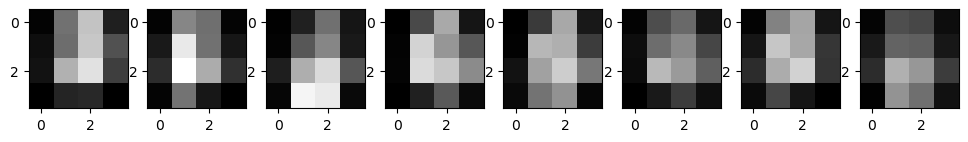

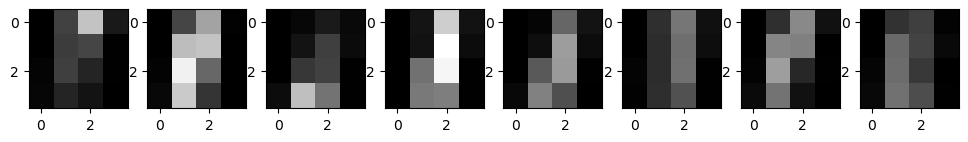

In [20]:
filts6 = np.array([ims.mean(axis=0) for ims in pool6])
filts1 = np.array([ims.mean(axis=0) for ims in pool1])

plots(filts6)
plots(filts1)

We can see that _filts1_ is pretty consistent with the shape of a _one_ image with no consideration of the very left and right pixel columns

Now we define a function that correlates a given image with all filters from ```filters``` and max pools the responses.

In [21]:
def pool_corr(im): return np.array([pool(correlate(im, filter)) for filter in filters])

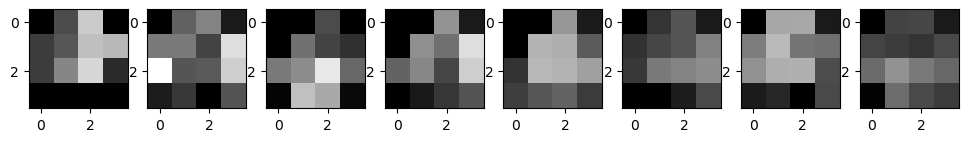

In [22]:
plots(pool_corr(sixes[1000]))

We define now a function which one of the two classes is most likely given the sse distances between the correlated ofthe image with all the filters and the canonical filters

In [23]:
# sum of squared distance
def sse(a,b): return ((a-b)**2).sum()

# is7 returns 1 if it thinks it's a seven and 0 otherwise
def is6(im): return 1 if sse(pool_corr(im),filts1) > sse(pool_corr(im),filts6) else 0

We perform a check to see if our function actually works. We correlate an image of _eight_ with ```filts6``` and ```filts1```. It should give smaller distance for the _sixes_

In [24]:
sse(pool_corr(sixes[0]), filts6), sse(pool_corr(sixes[0]), filts1)

(11.102158, 53.825996)

We now test our classifier on the 1000 images of _sevens_ and 1000 images of _ones_

In [25]:
nb_6_predicted_6 = np.array([is6(im) for im in sixes[:1000]]).sum()
nb_1_predicted_1 = np.array([(1-is6(im)) for im in ones[:1000]]).sum()


acc_1 = nb_1_predicted_1/1000
acc_6 = nb_6_predicted_6/1000
acc = (acc_1 + acc_6)/2

print('accuracy :', acc)

accuracy : 0.971


Let's just build the confusion matrix

In [26]:
true_positives=nb_6_predicted_6
false_positives=np.array([is6(im) for im in ones[:1000]]).sum()
true_negatives=nb_1_predicted_1 
false_negatives=np.array([1-is6(im) for im in sixes[:1000]]).sum()

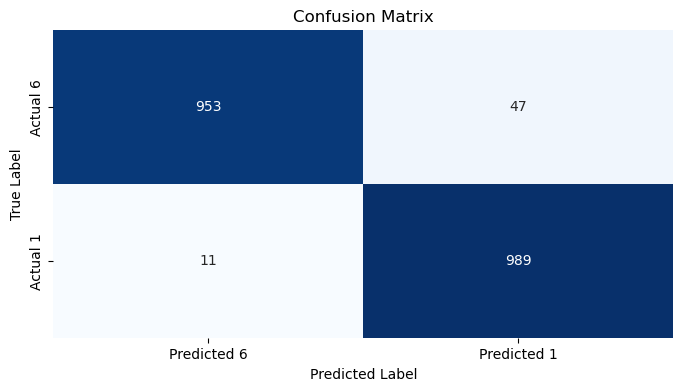

In [27]:
import seaborn as sns

# Construct the confusion matrix
def confusion_matrix(true_positives,false_negatives,false_positives,true_negatives):
    confusion_matrix = np.array([[true_positives, false_negatives],  # Row for true 7s
                                [false_positives, true_negatives]])  # Row for true 1s

    # Plotting
    plt.figure(figsize=(8, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Predicted 6", "Predicted 1"],
                yticklabels=["Actual 6", "Actual 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

confusion_matrix(true_positives,false_negatives,false_positives,true_negatives)

We have successfully built a classifier for _sevens_ and _ones_ using features extracted with a hand-crafted bank of filters and a set of training samples. 

Let's just test what the classifier predicts when we have another number than just six and one :

Since we know an ```8``` is closer to a ```6``` in shape than to a ```1``` because of the loop, we expect our classifier to predict mostly _sixes_ for the _eights_

In [28]:
eights=[images[i] for i in range(n) if labels[i]==8]
nb_8_predicted_6 = np.array([is6(im) for im in eights]).sum()
nb_8_predicted_1 = np.array([1-is6(im) for im in eights]).sum()

In [29]:
print(len(eights),nb_8_predicted_6,nb_8_predicted_1,'\n\n')

print(f'The percentage of 8 predicted as 6 is : {nb_8_predicted_6*100//len(eights)} %')

5851 5249 602 


The percentage of 8 predicted as 6 is : 89 %


## Improving classification with convolutional neural networks

We now build a neural net that will learn the filters.

The first layer of the network will be a convolutional layer with $8$ filters of size $3\times 3$. We choose padding such that the output feature maps have a size of $28 \times 28$. Then we apply a Max Pooling layer to reduce the size of the image to $4\times 4$ as we did above. This will produce (once flatten) a vector of size $128 = 4\times 4\times 8$. From this vector, we want to predict if the corresponding input is a $1$ or a $6$.

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    def __init__(self):
        super(classifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1) # conv layer
        self.mp1 = nn.MaxPool2d(kernel_size=7) # max pooling
        self.fc = nn.Linear(in_features=128, out_features=1) # fully-connected layer
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        
        x=self.conv1(x)
        x=self.mp1(x)
        x = torch.flatten(x, start_dim=1)
        x=self.fc(x)
        x=self.sigmoid(x)

        return x

In [31]:
conv_class = classifier()

Our code should work fine on a batch of 3 images.

In [32]:
batch_3images = train_set.data[0:2].type(torch.FloatTensor).resize_(3, 1, 28, 28)
out = conv_class(batch_3images)
print(out.shape)

torch.Size([3, 1])


Let's build the datasets and the dataloaders

In [33]:
bs = 64 # batch size

l6 = np.array(0) # label for sixes
sixes_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                   torch.from_numpy(l6.astype(np.float32))] for e in sixes] # input images of sixes

l1 = np.array(1) # label for ones
ones_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                 torch.from_numpy(l1.astype(np.float32))] for e in ones] # input images of ones

train_dataset = sixes_dataset[1000:] + ones_dataset[1000:]
test_dataset = sixes_dataset[:1000] + ones_dataset[:1000]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True)

We now define the train function. We store the loss and accuracy for each epoch. To compute the number of correct predictions, we simply threshold the output of your network and compare with the labels.

In [34]:
def train(model, data_loader, loss_fn, optimizer, n_epochs=1, scheduler=None):
    
    model.train(True)
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    
    for epoch_num in range(n_epochs):
        
        running_corrects = 0.0  # Number of correct predictions
        running_loss = 0.0      # Loss
        size = 0

        for data in data_loader:
            
            inputs, labels = data
            labels = labels.unsqueeze(1)
            bs = labels.size(0)

            # Reset the stored gradients for the parameters of the neural network
            model.zero_grad() 

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = loss_fn(outputs, labels) 

            # Backward pass
            loss.backward() 

            # Gradient descent step
            optimizer.step()

            running_loss += loss.item() * bs
            preds = (outputs >= 0.5).type(torch.float32)
            running_corrects += torch.sum(preds == labels)
            
            # Count the number of samples
            size += bs
            
        # Calculate the loss and accuracy for this epoch
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.item() / size
        
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        
        print('Epoch {} - Loss: {:.4f} Acc: {:.4f}'.format(epoch_num+1, epoch_loss, epoch_acc))

        # Step the scheduler at the end of the epoch, if a scheduler is provided
        if scheduler:
            scheduler.step()

    return loss_train, acc_train


In [35]:
from torch.optim.lr_scheduler import StepLR  
conv_class = classifier()

# an appropriate loss
loss_fn = nn.BCELoss(reduction='mean')

# the optimizer
learning_rate = 1e-2
optimizer_cl = torch.optim.Adam(conv_class.parameters(), lr=learning_rate)

# number of epochs
n_epochs = 40

# scheduler 
scheduler=StepLR(optimizer=optimizer_cl,step_size=10,gamma=0.9)

# and train
training_loss, training_acc = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = n_epochs,scheduler=scheduler)

Epoch 1 - Loss: 0.0904 Acc: 0.9741
Epoch 2 - Loss: 0.0123 Acc: 0.9961
Epoch 3 - Loss: 0.0096 Acc: 0.9965
Epoch 4 - Loss: 0.0071 Acc: 0.9978
Epoch 5 - Loss: 0.0079 Acc: 0.9973
Epoch 6 - Loss: 0.0074 Acc: 0.9977
Epoch 7 - Loss: 0.0056 Acc: 0.9980
Epoch 8 - Loss: 0.0058 Acc: 0.9977
Epoch 9 - Loss: 0.0040 Acc: 0.9988
Epoch 10 - Loss: 0.0043 Acc: 0.9980
Epoch 11 - Loss: 0.0035 Acc: 0.9987
Epoch 12 - Loss: 0.0040 Acc: 0.9988
Epoch 13 - Loss: 0.0033 Acc: 0.9989
Epoch 14 - Loss: 0.0041 Acc: 0.9986
Epoch 15 - Loss: 0.0036 Acc: 0.9989
Epoch 16 - Loss: 0.0027 Acc: 0.9992
Epoch 17 - Loss: 0.0026 Acc: 0.9992
Epoch 18 - Loss: 0.0028 Acc: 0.9989
Epoch 19 - Loss: 0.0017 Acc: 0.9994
Epoch 20 - Loss: 0.0029 Acc: 0.9991
Epoch 21 - Loss: 0.0025 Acc: 0.9992
Epoch 22 - Loss: 0.0021 Acc: 0.9993
Epoch 23 - Loss: 0.0016 Acc: 0.9993
Epoch 24 - Loss: 0.0013 Acc: 0.9996
Epoch 25 - Loss: 0.0016 Acc: 0.9997
Epoch 26 - Loss: 0.0021 Acc: 0.9992
Epoch 27 - Loss: 0.0021 Acc: 0.9992
Epoch 28 - Loss: 0.0013 Acc: 0.9996
E

Text(0, 0.5, 'BCE loss')

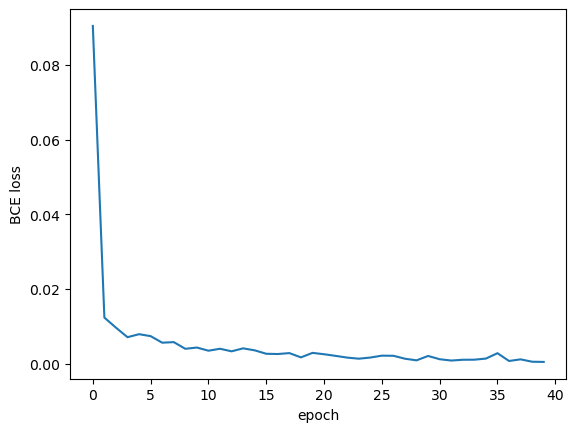

In [36]:
plt.plot(training_loss)
plt.xlabel('epoch')
plt.ylabel('BCE loss')

Text(0, 0.5, 'accuracy')

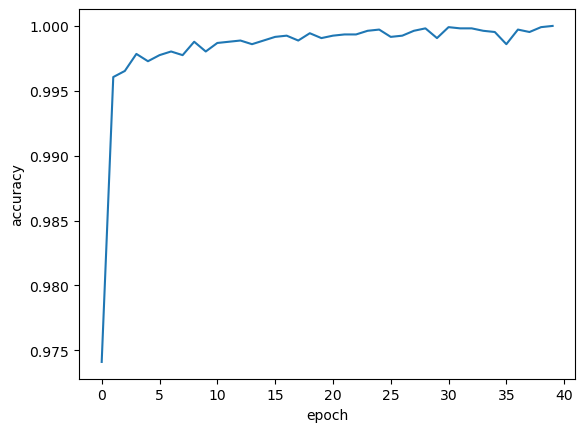

In [37]:
plt.plot(training_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')

Our network seems to learn but we now need to check its accuracy on the test set.

In [38]:
def test(model,data_loader):
    
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        
        inputs, labels = data
        labels = labels.unsqueeze(1)
        bs = labels.size(0)

        # reset the stored gradients for the parameters of the neural network
        model.zero_grad() 

        # do the forward pass
        outputs = model(inputs)

        # compute the loss on the training set
        loss = loss_fn(outputs, labels)    
        
        # store loss and compute num. of correct predictions
        running_loss += loss
        preds = (outputs >= 0.5).type(torch.float32)
        running_corrects += torch.sum(preds == labels)

        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [39]:
test(conv_class,test_loader)

Test - Loss: 0.0002 Acc: 0.9980


We have slightly improved the performance compared with the handcrafted set of filters.

Let's verify the number of parameters our network learned

In [40]:
print(f'The number of parameters learned is : {np.array([x.flatten().size()[0] for x in list(conv_class.parameters())]).sum()}')

The number of parameters learned is : 209


We can see the learned filters as follows:

In [41]:
for p in conv_class.parameters():
    T_w = p.data.numpy()
    break

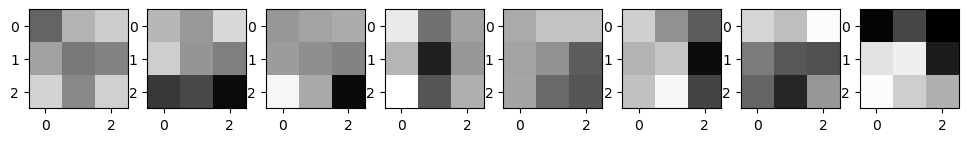

In [42]:
plots([T_w[i][0] for i in range(8)])

## Multiclass classification with CNNs

We now build a neural net that will be able to predict the class amond the 10 classes of digit [0,1,...,9]

We can use the same architecture as before but the difference will be the output dimension and the loss

In [43]:
class MultiClassifier(nn.Module):
    
    def __init__(self):
        super(MultiClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1) # conv layer
        self.mp1 = nn.MaxPool2d(kernel_size=7) # max pooling
        self.fc = nn.Linear(in_features=128, out_features=10) # because there is 10 classes

    def forward(self,x):
        
        x=self.conv1(x)
        x=self.mp1(x)
        x = torch.flatten(x, start_dim=1)
        x=self.fc(x)

        return x

In [44]:
transformation=transforms.ToTensor()


train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=transformation)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=transformation)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=128,shuffle=True)


train_set.__len__(),test_set.__len__()

(60000, 10000)

In [45]:
def train_mc(model, data_loader, loss_fn, optimizer, n_epochs=1, scheduler=None):
    
    model.train(True)
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    
    for epoch_num in range(n_epochs):
        
        running_corrects = 0.0  # Number of correct predictions
        running_loss = 0.0      # Loss
        size = 0

        for data in data_loader:
            
            inputs, labels = data
            
            bs = labels.size(0)

            # Reset the stored gradients for the parameters of the neural network
            model.zero_grad() 

            # Forward pass
            outputs = model(inputs)

            
            # Compute the loss
            loss = loss_fn(outputs, labels)
      
            # Backward pass
            loss.backward() 

            # Gradient descent step
            optimizer.step()

            running_loss += loss.item() * bs
            
            # we get the predicted labels by taking the highest probability for each image
            predicted_labels = torch.argmax(outputs, dim=1)

            running_corrects += torch.sum(predicted_labels == labels)
            
            # Count the number of samples
            size += bs
            
        # Calculate the loss and accuracy for this epoch
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.item() / size
        
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        
        print('Epoch {} - Loss: {:.4f} Acc: {:.4f}'.format(epoch_num+1, epoch_loss, epoch_acc))

        # Step the scheduler at the end of the epoch, if a scheduler is provided
        if scheduler:
            scheduler.step()

    return loss_train, acc_train
    

In [46]:
# model
model=MultiClassifier()

# loss function for multi-class classification
multiclass_loss = nn.CrossEntropyLoss()

# the optimizer
learning_rate = 1e-2
optimizer_mc = torch.optim.Adam(model.parameters(), lr=learning_rate)

# number of epochs
n_epochs = 15

# scheduler 
scheduler=StepLR(optimizer=optimizer_mc,step_size=1,gamma=0.9)

training_loss, acc_train = train_mc(model, train_loader, multiclass_loss, optimizer_mc, n_epochs, scheduler)

Epoch 1 - Loss: 0.3353 Acc: 0.8981
Epoch 2 - Loss: 0.1311 Acc: 0.9583
Epoch 3 - Loss: 0.1115 Acc: 0.9637
Epoch 4 - Loss: 0.1027 Acc: 0.9677
Epoch 5 - Loss: 0.0971 Acc: 0.9693
Epoch 6 - Loss: 0.0927 Acc: 0.9708
Epoch 7 - Loss: 0.0896 Acc: 0.9712
Epoch 8 - Loss: 0.0862 Acc: 0.9730
Epoch 9 - Loss: 0.0842 Acc: 0.9734
Epoch 10 - Loss: 0.0830 Acc: 0.9737
Epoch 11 - Loss: 0.0804 Acc: 0.9749
Epoch 12 - Loss: 0.0796 Acc: 0.9748
Epoch 13 - Loss: 0.0780 Acc: 0.9756
Epoch 14 - Loss: 0.0767 Acc: 0.9758
Epoch 15 - Loss: 0.0757 Acc: 0.9759


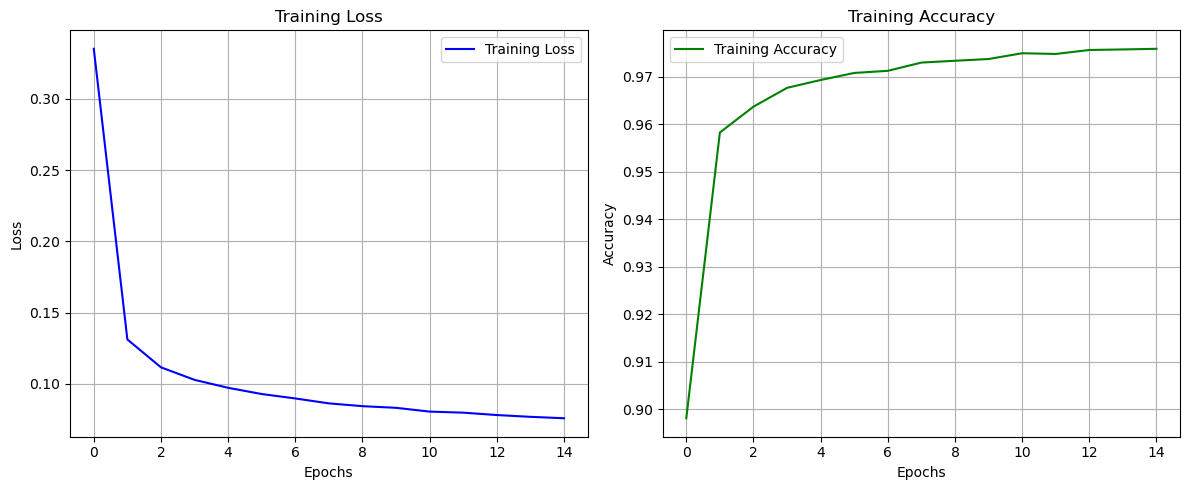

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Tracer la courbe de loss dans le premier sous-graphe
axes[0].plot(training_loss, label='Training Loss', color='blue')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

# Tracer la courbe d'accuracy dans le second sous-graphe
axes[1].plot(acc_train, label='Training Accuracy', color='green')
axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [48]:
def test(model,data_loader,loss_fn):
    
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        
        inputs, labels = data
        labels = labels
        bs = labels.size(0)

        # reset the stored gradients for the parameters of the neural network
        model.zero_grad() 

        # do the forward pass
        outputs = model(inputs)

        # compute the loss on the training set
        loss = loss_fn(outputs, labels)    
        
        # store loss and compute num. of correct predictions
        running_loss += loss
        
        # we get the predicted labels
        predicted_labels = torch.argmax(outputs, dim=1)

        running_corrects += torch.sum(predicted_labels == labels)

        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [49]:
test(model,test_loader,multiclass_loss)

Test - Loss: 0.0006 Acc: 0.9738
